<a href="https://colab.research.google.com/github/7201krap/PYTORCH_project/blob/main/selectivity_4_optim_5_nums.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
import numpy as np
from google.colab import drive

import os
import subprocess as sp
from torchvision.datasets.mnist import MNIST, read_image_file, read_label_file
from torchvision.datasets.utils import extract_archive

drive.mount('/content/drive')

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(1234)
np.random.seed(1234)

In [3]:
def patched_download(self):
    """wget patched download method.
    """
    if self._check_exists():
        return

    os.makedirs(self.raw_folder, exist_ok=True)
    os.makedirs(self.processed_folder, exist_ok=True)

    # download files
    for url, md5 in self.resources:
        filename = url.rpartition('/')[2]
        download_root = os.path.expanduser(self.raw_folder)
        extract_root = None
        remove_finished = False

        if extract_root is None:
            extract_root = download_root
        if not filename:
            filename = os.path.basename(url)
        
        # Use wget to download archives
        sp.run(["wget", url, "-P", download_root])

        archive = os.path.join(download_root, filename)
        print("Extracting {} to {}".format(archive, extract_root))
        extract_archive(archive, extract_root, remove_finished)

    # process and save as torch files
    print('Processing...')

    training_set = (
        read_image_file(os.path.join(self.raw_folder, 'train-images-idx3-ubyte')),
        read_label_file(os.path.join(self.raw_folder, 'train-labels-idx1-ubyte'))
    )
    test_set = (
        read_image_file(os.path.join(self.raw_folder, 't10k-images-idx3-ubyte')),
        read_label_file(os.path.join(self.raw_folder, 't10k-labels-idx1-ubyte'))
    )
    with open(os.path.join(self.processed_folder, self.training_file), 'wb') as f:
        torch.save(training_set, f)
    with open(os.path.join(self.processed_folder, self.test_file), 'wb') as f:
        torch.save(test_set, f)

    print('Done!')


MNIST.download = patched_download

In [4]:
mnist_trainset = MNIST(root='./data', train=True, 
                                download=True, 
                                transform=transforms.Compose([transforms.ToTensor()]))

mnist_testset  = MNIST(root='./data', 
                                train=False, 
                                download=True, 
                                transform=transforms.Compose([transforms.ToTensor()]))

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw
Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw
Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw
Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:479: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
# class_inds 이거는 그냥 위에있는거를 list 로 만들어준 형태임 
class_inds = [torch.where(mnist_trainset.targets == class_idx)[0]
              for class_idx in mnist_trainset.class_to_idx.values()]

In [6]:
train_dataloaders = [
                     DataLoader(dataset=Subset(mnist_trainset, inds),
                                batch_size=10,
                                shuffle=True,
                                drop_last=False
                     )
                     for inds in class_inds
]

test_dataloader  = torch.utils.data.DataLoader(mnist_testset, 
                                               batch_size=50, 
                                               shuffle=False)

print("Training dataset size: ", len(mnist_trainset))
print("Testing dataset size: ",  len(mnist_testset))

Training dataset size:  60000
Testing dataset size:  10000


In [7]:
# ************* modify this section for later use *************
# Define the model 
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # modify this section for later use 
        self.linear_1 = torch.nn.Linear(784, 256)
        self.linear_2 = torch.nn.Linear(256, 10)
        self.sigmoid12  = torch.nn.Sigmoid()

        self.layer_activations = dict()

    def forward(self, x):

        # modify this section for later use 
        x = x.reshape(x.size(0), -1)
        x = self.linear_1(x)
        x = self.sigmoid12(x)
        pred = self.linear_2(x)
        return pred
# ************* modify this section for later use *************

In [8]:
def get_activation(model, layer_name):    
    def hook(module, input, output):
        model.layer_activations[layer_name] = output
    return hook

In [9]:
def selectivity(hidden_layer_each_neuron):
    __selectivity__ = list()
    # I will now try to find the average of each class for each neuron.
    # check out the next cell 
    avg_activations = [dict() for x in range(256)]
    for i, neuron in enumerate(hidden_layer_each_neuron):
        for k, v in neuron.items():
            # v is the list of activations for hidden layer's neuron k 
            avg_activations[i][k] = sum(v) / float(len(v))

    # generate 256 lists to get only values in avg_activations
    only_activation_vals = [list() for x in range(256)]

    # get only values from avg_activations
    for i, avg_activation in enumerate(avg_activations):
        for value in avg_activation.values():
            only_activation_vals[i].append(value)


    for activation_val in only_activation_vals:
        # find u_max 
        u_max = np.max(activation_val)

        # find u_minus_max 
        u_minus_max = (np.sum(activation_val) - u_max) / 9

        # find selectivity 
        selectivity = (u_max - u_minus_max) / (u_max + u_minus_max)

        # append selectivity value to selectivity
        __selectivity__.append(selectivity)

    avg_selectivity = np.average(__selectivity__)
    std_selectivity = np.std(__selectivity__)
                                 
    return avg_selectivity, std_selectivity

In [10]:
def model_factory(optimizer_name):
    '''
    optimizer_name : choose one of Adagrad, Adadelta, SGD, and Adam 

    '''
    my_model = Model()
    print("my_model:", my_model)
    my_model.to(device)

    # ************* modify this section for later use *************
    my_model.sigmoid12.register_forward_hook(get_activation(my_model, 's12'))
    # ************* modify this section for later use *************

    if optimizer_name == 'Adadelta':
        my_optimizer = torch.optim.Adadelta(my_model.parameters(), lr=1.0)

    elif optimizer_name == 'Adagrad':
        my_optimizer = torch.optim.Adagrad(my_model.parameters(), lr=0.1)

    elif optimizer_name == 'SGD':
        my_optimizer = torch.optim.SGD(my_model.parameters(), lr=0.1)

    elif optimizer_name == 'Adam':
        my_optimizer = torch.optim.Adam(my_model.parameters(), lr=0.001)

    else:
        print("ERROR")
    
    print("my_optimizer:", my_optimizer)
    test_acc, selectivity_list_avg, selectivity_list_std = selectivity_trainer(optimizer=my_optimizer, model=my_model)
    # ************* modify this section for later use *************
    file_saver = open(f"selectivity_4_optim_5_nums_{optimizer_name}.txt", "w")
    # ************* modify this section for later use *************
    file_saver.write(str(test_acc)+'\n'+str(selectivity_list_avg)+'\n'+str(selectivity_list_std)+'\n\n')
    file_saver.close()

    # ************* modify this section for later use *************
    if optimizer_name == 'Adadelta':
        !cp selectivity_4_optim_5_nums_Adadelta.txt /content/drive/MyDrive
    
    elif optimizer_name == 'Adagrad':
        !cp selectivity_4_optim_5_nums_Adagrad.txt /content/drive/MyDrive

    elif optimizer_name == 'SGD':
        !cp selectivity_4_optim_5_nums_SGD.txt /content/drive/MyDrive

    elif optimizer_name == 'Adam':
        !cp selectivity_4_optim_5_nums_Adam.txt /content/drive/MyDrive
    # ************* modify this section for later use *************

    else:
        print("ERROR")

In [11]:
# ************* modify this section for later use *************
def avg_std_calculator(_hidden_layer_each_neuron_12):

    avg_selectivity12, std_selectivity12 = selectivity(_hidden_layer_each_neuron_12)

    final_selectivity_avg = (avg_selectivity12) / 1
    final_selecvitity_std = (std_selectivity12) / 1

    return final_selectivity_avg, final_selecvitity_std
# ************* modify this section for later use *************

In [28]:
def selectivity_trainer(optimizer, model):
    criterion = torch.nn.CrossEntropyLoss()
    no_epochs = 30
    test_acc   = list()

    selectivity_avg_list = list()
    selectivity_std_list = list()

    for epoch in range(no_epochs):

        print(f"epoch {epoch} started")
        # ************* modify this section for later use *************
        hidden_layer_each_neuron_12 = [{0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[]} for x in range(256)]
        hidden_layer_each_neuron_12 = np.array(hidden_layer_each_neuron_12)
        # ************* modify this section for later use *************

        # TRAINING 
        model.train()
        iterators = list(map(iter, train_dataloaders))   
        while iterators:
            iterator = np.random.choice(iterators, 5, replace=False)
            try:
                image0, label0 = next(iterator[0]) 
                image1, label1 = next(iterator[1]) 
                image2, label2 = next(iterator[2]) 
                image3, label3 = next(iterator[3]) 
                image4, label4 = next(iterator[4]) 

                # concat batch_size 10 * 5 => 50
                images = torch.cat((image0, image1, image2, image3, image4), 0)
                labels = torch.cat((label0, label1, label2, label3, label4), 0)
                
                # This is needed!!
                indexes = torch.randperm(labels.shape[0])
                images = images[indexes]
                labels = labels[indexes]
                # This is needed!!

                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()

                pred = model(images)

                loss = criterion(pred, labels)

                loss.backward()
                optimizer.step()
                
            except StopIteration:
                iterators.remove(iterator[0])
                iterators.remove(iterator[1])
                iterators.remove(iterator[2])
                iterators.remove(iterator[3])
                iterators.remove(iterator[4])


        # TESTING
        model.eval()
        total = 0
        for itr, (images, labels) in enumerate(test_dataloader):
            images, labels = images.to(device), labels.to(device)

            pred = model(images)

            loss = criterion(pred, labels)

            # we now need softmax because we are testing.
            pred = torch.nn.functional.softmax(pred, dim=1)
            for i, p in enumerate(pred):
                if labels[i] == torch.max(p.data, 0)[1]:
                    total = total + 1

            # ************* modify this section for later use *************
            for activation, label in zip(model.layer_activations['s12'], labels):
                label = label.item()
                with torch.no_grad():
                    activation = activation.numpy()
                for i in range(256):    
                    hidden_layer_each_neuron_12[i][label].append(activation[i])
        
        selectivity_avg, selecvitity_std = avg_std_calculator(hidden_layer_each_neuron_12)
        # ************* modify this section for later use *************
            
        selectivity_avg_list.append(selectivity_avg)
        selectivity_std_list.append(selecvitity_std)

        accuracy = total / len(mnist_testset)

        # append accuracy here
        test_acc.append(accuracy)

        print('\nEpoch: {}/{}, Test Accuracy: {:.8f}'.format(epoch + 1, no_epochs, accuracy))
    
    print(selectivity_avg_list)
    print(selectivity_std_list)

    return test_acc, selectivity_avg_list, selectivity_std_list

# Adadelta

my_model: Model(
  (linear_1): Linear(in_features=784, out_features=256, bias=True)
  (linear_2): Linear(in_features=256, out_features=10, bias=True)
  (sigmoid12): Sigmoid()
)
my_optimizer: Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 1.0
    rho: 0.9
    weight_decay: 0
)
epoch 0 started
tensor([9, 8, 9, 1, 1, 9, 8, 8, 6, 8, 9, 9, 7, 9, 6, 6, 7, 1, 6, 7, 1, 1, 7, 6,
        1, 1, 8, 9, 8, 1, 7, 6, 1, 9, 6, 7, 7, 8, 7, 6, 8, 6, 7, 8, 9, 1, 7, 6,
        9, 8])


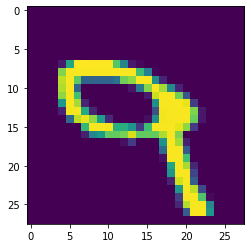

tensor([1, 3, 8, 8, 8, 0, 0, 9, 0, 3, 1, 9, 0, 3, 9, 3, 9, 1, 1, 3, 8, 9, 3, 3,
        8, 8, 0, 1, 9, 9, 1, 0, 0, 1, 3, 3, 1, 8, 1, 0, 1, 9, 0, 0, 3, 9, 8, 9,
        8, 8])


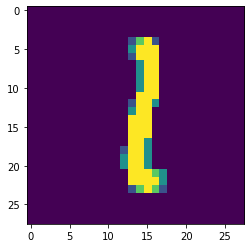

tensor([1, 7, 3, 3, 2, 2, 0, 7, 3, 7, 0, 7, 7, 2, 1, 3, 2, 7, 2, 2, 7, 3, 0, 0,
        1, 7, 0, 2, 0, 3, 1, 0, 1, 3, 0, 3, 2, 1, 3, 0, 0, 2, 2, 1, 1, 7, 1, 1,
        3, 7])


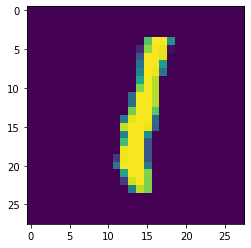

tensor([4, 9, 8, 9, 4, 4, 9, 8, 5, 8, 8, 9, 9, 4, 8, 4, 4, 4, 4, 9, 5, 7, 4, 9,
        7, 7, 7, 8, 5, 7, 5, 7, 9, 5, 9, 8, 5, 7, 7, 5, 5, 9, 4, 8, 5, 8, 5, 7,
        8, 7])


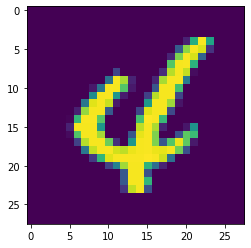

tensor([6, 4, 1, 2, 2, 5, 1, 5, 4, 4, 1, 1, 4, 2, 1, 5, 1, 2, 6, 4, 2, 2, 5, 5,
        6, 6, 4, 2, 5, 2, 6, 2, 1, 4, 6, 6, 1, 2, 5, 5, 4, 1, 6, 4, 5, 5, 1, 6,
        6, 4])


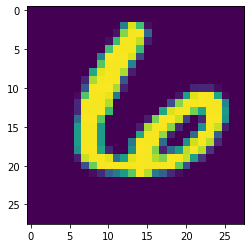

tensor([5, 5, 0, 3, 5, 0, 8, 0, 1, 1, 0, 5, 8, 0, 0, 1, 3, 1, 8, 1, 3, 8, 1, 8,
        0, 5, 1, 5, 8, 5, 3, 0, 8, 8, 3, 8, 3, 3, 0, 1, 1, 5, 3, 3, 5, 8, 3, 0,
        5, 1])


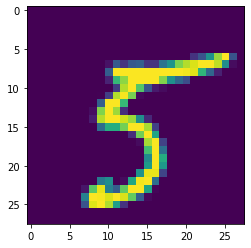

tensor([2, 7, 9, 2, 7, 7, 6, 6, 9, 2, 8, 6, 7, 6, 2, 8, 6, 2, 6, 2, 8, 7, 6, 2,
        7, 9, 8, 7, 9, 8, 7, 6, 2, 6, 8, 7, 6, 2, 9, 7, 9, 9, 9, 8, 8, 9, 9, 8,
        2, 8])


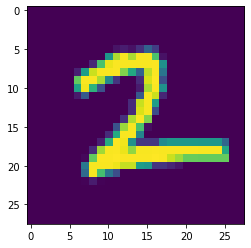

tensor([9, 8, 0, 0, 4, 4, 8, 4, 3, 8, 3, 3, 3, 9, 0, 0, 4, 9, 4, 3, 3, 8, 9, 0,
        4, 9, 9, 8, 0, 0, 4, 8, 4, 9, 4, 3, 8, 9, 3, 0, 3, 3, 0, 9, 8, 4, 9, 8,
        0, 8])


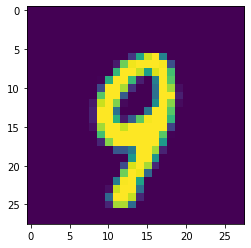

tensor([5, 3, 3, 1, 9, 3, 5, 3, 5, 3, 1, 5, 3, 8, 8, 9, 8, 3, 9, 8, 5, 9, 9, 1,
        9, 1, 5, 3, 5, 1, 5, 8, 9, 8, 9, 8, 1, 1, 3, 1, 5, 5, 8, 9, 9, 8, 1, 3,
        8, 1])


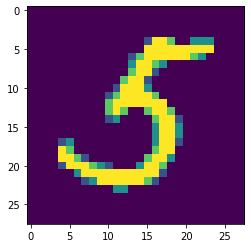

tensor([4, 8, 8, 4, 1, 7, 1, 1, 1, 1, 1, 7, 4, 6, 6, 8, 6, 8, 4, 1, 7, 6, 6, 7,
        4, 1, 4, 7, 7, 6, 6, 8, 8, 8, 8, 1, 6, 7, 1, 4, 4, 7, 6, 7, 8, 4, 8, 4,
        7, 6])


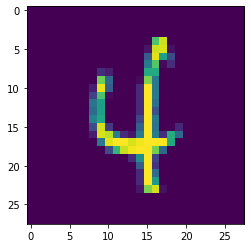

tensor([9, 7, 7, 7, 9, 5, 6, 2, 9, 5, 7, 7, 2, 9, 5, 9, 6, 7, 9, 7, 2, 7, 2, 2,
        2, 2, 5, 6, 2, 2, 5, 5, 5, 2, 6, 6, 6, 5, 6, 9, 6, 9, 5, 6, 6, 9, 7, 9,
        5, 7])


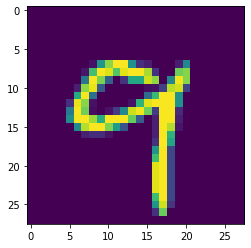

tensor([5, 5, 9, 7, 1, 9, 7, 1, 7, 7, 7, 5, 7, 5, 5, 9, 5, 5, 3, 9, 9, 5, 1, 3,
        3, 7, 1, 1, 3, 3, 7, 7, 1, 9, 5, 1, 3, 3, 3, 3, 9, 1, 1, 5, 1, 9, 9, 3,
        7, 9])


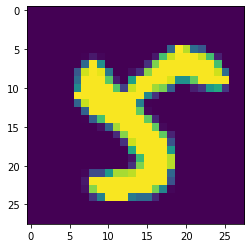

tensor([4, 3, 8, 9, 8, 4, 8, 3, 2, 2, 9, 8, 8, 2, 4, 4, 3, 3, 9, 3, 3, 8, 9, 4,
        3, 3, 8, 9, 9, 8, 4, 4, 4, 2, 2, 8, 9, 2, 4, 2, 3, 9, 9, 3, 2, 8, 4, 2,
        2, 9])


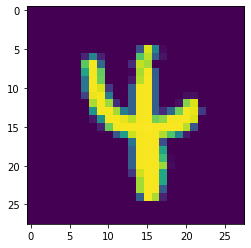

tensor([7, 5, 2, 5, 0, 0, 6, 5, 2, 7, 6, 5, 5, 7, 6, 7, 6, 5, 0, 6, 2, 2, 5, 6,
        6, 0, 0, 6, 2, 7, 0, 7, 0, 0, 5, 5, 0, 7, 6, 7, 2, 2, 2, 5, 2, 7, 0, 7,
        6, 2])


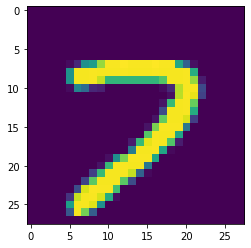

tensor([7, 5, 5, 6, 6, 6, 5, 1, 5, 7, 5, 5, 6, 5, 6, 2, 5, 7, 2, 2, 7, 5, 5, 2,
        1, 7, 1, 6, 2, 7, 6, 1, 2, 2, 6, 2, 1, 6, 6, 1, 1, 2, 1, 2, 1, 7, 7, 7,
        1, 7])


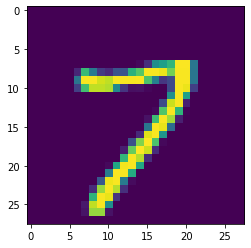

tensor([7, 6, 1, 5, 5, 8, 1, 8, 5, 5, 5, 5, 8, 6, 6, 8, 6, 5, 6, 7, 7, 5, 8, 7,
        7, 8, 6, 1, 1, 5, 1, 7, 8, 7, 7, 6, 7, 7, 1, 5, 6, 8, 1, 1, 1, 6, 8, 1,
        8, 6])


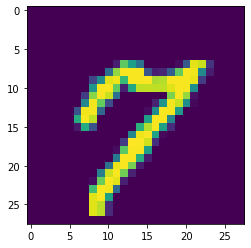

tensor([0, 7, 0, 7, 5, 8, 5, 5, 8, 5, 4, 7, 7, 4, 7, 5, 4, 5, 8, 5, 4, 0, 7, 0,
        7, 8, 7, 0, 8, 4, 7, 5, 8, 4, 0, 5, 5, 4, 0, 0, 8, 0, 8, 8, 4, 8, 7, 4,
        0, 4])


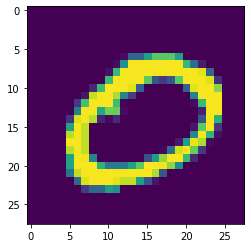

tensor([5, 8, 8, 5, 8, 7, 7, 6, 3, 6, 3, 6, 8, 6, 6, 3, 5, 5, 5, 3, 7, 6, 8, 7,
        3, 7, 5, 6, 6, 5, 8, 3, 7, 6, 3, 8, 7, 7, 7, 8, 3, 3, 5, 8, 5, 3, 7, 6,
        5, 8])


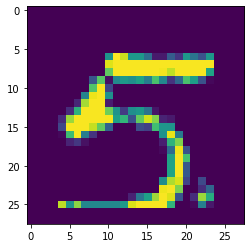

tensor([8, 1, 8, 1, 1, 1, 4, 2, 4, 2, 0, 4, 4, 8, 1, 8, 8, 2, 0, 2, 0, 0, 2, 2,
        1, 4, 8, 8, 1, 0, 0, 1, 8, 2, 8, 2, 2, 0, 8, 1, 4, 1, 0, 4, 4, 0, 0, 4,
        2, 4])


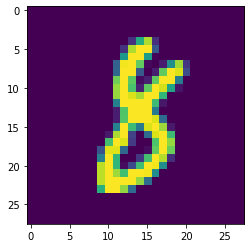

tensor([4, 8, 0, 6, 3, 0, 8, 6, 4, 4, 8, 4, 8, 3, 0, 3, 3, 8, 3, 4, 0, 6, 3, 8,
        4, 4, 3, 0, 3, 6, 0, 8, 6, 0, 6, 4, 0, 6, 6, 0, 3, 6, 8, 6, 4, 4, 3, 8,
        8, 0])


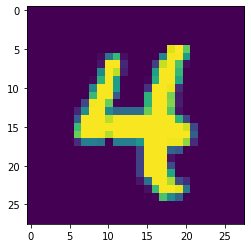

tensor([1, 8, 1, 3, 6, 6, 3, 6, 6, 4, 4, 6, 3, 8, 1, 1, 3, 8, 1, 3, 1, 3, 4, 3,
        3, 4, 3, 1, 1, 8, 4, 1, 4, 6, 6, 8, 6, 3, 4, 6, 4, 6, 4, 8, 1, 8, 8, 8,
        4, 8])


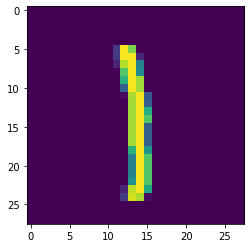

tensor([2, 0, 0, 2, 1, 7, 6, 6, 6, 1, 1, 7, 2, 7, 7, 2, 0, 6, 2, 1, 6, 2, 0, 6,
        2, 0, 1, 7, 1, 0, 2, 2, 0, 7, 7, 7, 1, 1, 6, 6, 0, 6, 1, 2, 0, 0, 6, 7,
        7, 1])


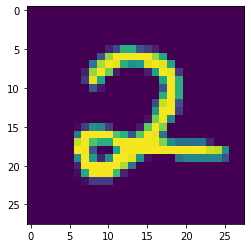

tensor([7, 9, 2, 2, 2, 1, 1, 1, 9, 2, 9, 5, 2, 1, 5, 2, 9, 5, 7, 1, 2, 2, 2, 7,
        9, 9, 7, 7, 5, 5, 7, 5, 9, 1, 9, 1, 5, 5, 9, 1, 1, 2, 7, 9, 7, 7, 5, 7,
        1, 5])


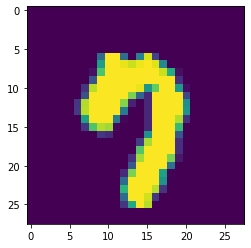

tensor([2, 7, 0, 8, 6, 0, 2, 7, 7, 6, 6, 0, 6, 6, 0, 2, 8, 8, 8, 2, 7, 0, 2, 7,
        2, 6, 8, 6, 0, 8, 8, 2, 0, 8, 2, 7, 7, 2, 7, 8, 7, 0, 2, 8, 0, 6, 7, 6,
        0, 6])


KeyboardInterrupt: ignored

<Figure size 432x288 with 0 Axes>

In [29]:
model_factory('Adadelta')

# Adagrad

In [ ]:
model_factory('Adagrad')

# SGD

In [ ]:
model_factory('SGD')

# Adam

In [ ]:
model_factory('Adam')